In [2]:
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import glob
import os

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class SingleDeformer:
    def __init__(self, img_size) -> None:
        self.img_size = img_size
        area_ratio=(0.02, 0.15)
        aspect_ratio=((0.3, 1),(1, 3.3))
        #Map a target rectangle onto a source quad
        img_area = self.img_size[0] * self.img_size[1]
        patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
        patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
        patch_w  = int(np.sqrt(patch_area*patch_aspect))
        patch_h = int(np.sqrt(patch_area/patch_aspect))
        org_w, org_h = self.img_size
        self.crop_left, self.crop_top = random.randint(25, (org_w - patch_w)-25), random.randint(25, (org_h - patch_h)-25)
        self.crop_right, self.crop_bottom = self.crop_left + patch_w, self.crop_top + patch_h
        self.paste_left, self.paste_top = random.randint(25, (org_w - patch_w)-25), random.randint(25, (org_h - patch_h)-25)
    def getmesh(self, img):
        return [(
                # target rectangle
                (self.crop_left, self.crop_top,self.crop_right, self.crop_bottom),
                # corresponding source quadrilateral
                (np.random.randint(25, 200), 
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200))
                )]

In [5]:
def generate_rotations(image:Image):
  r90 = image.rotate(90)
  r180 = image.rotate(180)
  r270 = image.rotate(270)
  return image, r90, r180, r270


def generate_patch(image:Image, 
                    area_ratio=(0.02, 0.15), 
                    aspect_ratio=((0.3, 1),(1, 3.3))):
  #print('generate_patch', area_ratio)
  img_area = image.size[0] * image.size[1]
  patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
  patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
  patch_w  = int(np.sqrt(patch_area*patch_aspect))
  patch_h = int(np.sqrt(patch_area/patch_aspect))
  org_w, org_h = image.size
  deformed = ImageOps.deform(image, SingleDeformer(image.size))
  patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
  paste_left, paste_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  
  return deformed.crop((patch_left, patch_top, patch_right, patch_bottom)), (paste_left, paste_top)


def paste_patch(image, patch, coords, mask = None):
  aug_image = image.copy()
  aug_image.paste(patch, (coords[0], coords[1]), mask=mask)
  return aug_image


def apply_patch_augmentations(patch:Image, 
                              augmentations:transforms.ColorJitter=None):
  #patch = patch.filter(ImageFilter.GaussianBlur(random.randint(0, 2)))
  return augmentations(patch)


def random_color():
  return random.randint(10,240)


def generate_scar(imsize:tuple, 
                  w_range=(2,16), 
                  h_range=(10,25)):
  img_w, img_h = imsize

  #dimensioni sezione
  scar_w = random.randint(w_range[0], w_range[1])
  scar_h = random.randint(h_range[0], h_range[1])

  r = random_color()
  g = random_color()
  b = random_color()

  color = (r,g,b)

  scar = Image.new('RGBA', (scar_w, scar_h), color=color)
  angle = random.randint(-45, 45)
  scar = scar.rotate(angle, expand=True)

  #posizione casuale della sezione
  left, top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
  return scar, (left, top)

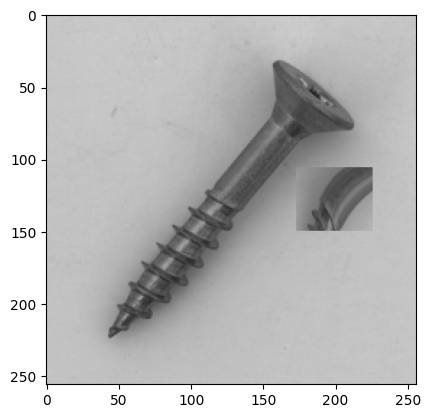

In [26]:
imsize=(256,256)
img = Image.open("../dataset/screw/train/good/000.png").resize(imsize).convert('RGB')
#patch, coords = generate_patch(img)
sd = SingleDeformer(img.size)
deformed = ImageOps.deform(img, sd)
plt.imshow(paste_patch(
    img, 
    deformed.crop((sd.crop_left, sd.crop_top, sd.crop_right, sd.crop_bottom)), 
    (sd.paste_left, sd.paste_top)))
#plt.imshow(paste_patch(img, patch, coords))